In [2]:
from bayes3d.dino import Dino
import bayes3d as b
import os
import torch
import numpy as np
import matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T
import bayes3d.ycb_loader
import bayes3d.o3d_viz

/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dino = dinov2_vitg14.to(device)  # Same issue with larger model
feat_dim = 1536 # vitg14

Using cache found in /home/nishadgothoskar/.cache/torch/hub/facebookresearch_dinov2_main


In [5]:

def get_embeddings(rgbd):
    img = b.get_rgb_image(rgbd.rgb).convert('RGB')
    patch_h, patch_w = np.array(img.size) // 14
    transform = T.Compose([
        T.GaussianBlur(9, sigma=(0.1, 2.0)),
        T.Resize((patch_h * 14, patch_w * 14)),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    tensor = transform(img)[:3].unsqueeze(0).to(device)
    with torch.no_grad():
        features_dict = dinov2_vitg14.forward_features(tensor)
        features = features_dict['x_norm_patchtokens'][0].reshape((patch_h, patch_w, feat_dim)).permute(2, 0, 1).unsqueeze(0)
    print(features.shape)
    features = torch.nn.functional.interpolate(
        features, [img.height, img.width], mode="bilinear", align_corners=True
    )
    img_feat_norm = torch.nn.functional.normalize(features, dim=1)
    output = jnp.array(img_feat_norm.cpu().detach().numpy())[0]
    del img_feat_norm
    del features
    del tensor
    del features_dict
    torch.cuda.empty_cache()
    return output

In [6]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.ycb_loader.get_test_img('49', '1', bop_ycb_dir)


In [7]:
viz = b.o3d_viz.O3DVis(rgbd.intrinsics)

[Open3D INFO] EGL headless mode enabled.


In [8]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_paths = []
for idx in range(1,22):
    mesh_paths.append(os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply"))
SCALING_FACTOR = 1.0/1000.0

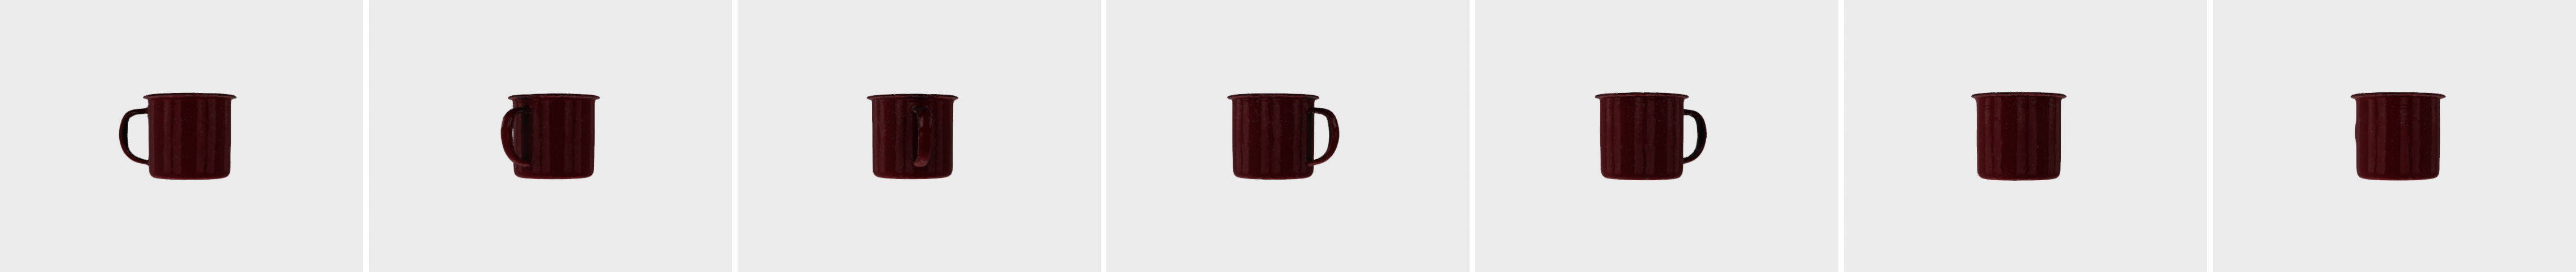

In [10]:

import open3d as o3d
rendered_images = []
object_poses = []
mesh_filename = mesh_paths[13]
for angle in jnp.linspace(0.0, jnp.pi * 2, 8)[:-1]:
    viz.clear()
    mesh = o3d.io.read_triangle_model(mesh_filename)
    pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)
    object_poses.append(pose)

    mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
    mesh.meshes[0].mesh.transform(pose)
    viz.render.scene.add_model(f"1", mesh)

    rendered_rgbd = viz.capture_image(rgbd.intrinsics, jnp.eye(4))
    rendered_images.append(rendered_rgbd)
b.hstack_images([b.get_rgb_image(r.rgb) for r in rendered_images])

In [11]:
embeddings = [get_embeddings(i) for i in rendered_images]
masks = [jnp.inf != i.depth for i in rendered_images]
pixel_coords = [jnp.vstack(jnp.where(m)) for m in masks]

/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])


In [15]:
len(embeddings)

7

In [18]:
embeddings[0].shape

(1536, 480, 640)

In [13]:
embeddings_np = np.array(jnp.array(embeddings))

2023-05-15 20:53:38.085474: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12.30GiB (rounded to 13212057600)requested by op 
2023-05-15 20:53:38.085697: W external/tsl/tsl/framework/bfc_allocator.cc:497] **************************************____**************************___*************_***************
2023-05-15 20:53:38.086290: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2432] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 13212057600 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   12.30GiB
              constant allocation:         0B
        maybe_live_out allocation:   12.30GiB
     preallocated temp allocation:         0B
                 total allocation:   24.61GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 12.30GiB
		Operator: op_name="jit(concatenate)/jit(main)/conc

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 13212057600 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   12.30GiB
              constant allocation:         0B
        maybe_live_out allocation:   12.30GiB
     preallocated temp allocation:         0B
                 total allocation:   24.61GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 12.30GiB
		Operator: op_name="jit(concatenate)/jit(main)/concatenate[dimension=0]" source_file="/tmp/ipykernel_89398/938604276.py" source_line=1
		XLA Label: concatenate
		Shape: f32[7,1536,480,640]
		==========================

	Buffer 2:
		Size: 1.76GiB
		Entry Parameter Subshape: f32[1,1536,480,640]
		==========================

	Buffer 3:
		Size: 1.76GiB
		Entry Parameter Subshape: f32[1,1536,480,640]
		==========================

	Buffer 4:
		Size: 1.76GiB
		Entry Parameter Subshape: f32[1,1536,480,640]
		==========================

	Buffer 5:
		Size: 1.76GiB
		Entry Parameter Subshape: f32[1,1536,480,640]
		==========================

	Buffer 6:
		Size: 1.76GiB
		Entry Parameter Subshape: f32[1,1536,480,640]
		==========================

	Buffer 7:
		Size: 1.76GiB
		Entry Parameter Subshape: f32[1,1536,480,640]
		==========================

	Buffer 8:
		Size: 1.76GiB
		Entry Parameter Subshape: f32[1,1536,480,640]
		==========================



In [ ]:
embeddings_np.shape

In [12]:
np.savez("dino.data", embeddings=embeddings, masks=masks)

In [20]:
key = jax.random.PRNGKey(10)

In [21]:
mesh = b.mesh.load_mesh(mesh_filename)
mesh.vertices *= SCALING_FACTOR
b.show_trimesh("1", mesh)

In [22]:
sparse_descriptors = []
for t1 in range(len(embeddings)):
    t2 = (t1+1) % len(embeddings)
    print("t1,t2", (t1,t2))
    keys = jax.random.split(key)[1]
    pixel_coords_subsampled = pixel_coords[t1][:,jax.random.choice(key, pixel_coords[t1].shape[1], (300,))]
    selected_embeddings = embeddings[t1][:, pixel_coords_subsampled[0], pixel_coords_subsampled[1]]
    similarity = jnp.einsum("iab, ik->abk", embeddings[t2], selected_embeddings)
    max_similarities = similarity.max([0,1])
    high_match_indices = (max_similarities > 0.95)
    
    print(high_match_indices.sum())
    high_match_embeddings = selected_embeddings[:, high_match_indices]

    high_match_pixel_coords = pixel_coords_subsampled[:, high_match_indices]
    point_cloud_image = b.t3d.unproject_depth(rendered_images[t1].depth, rendered_images[t1].intrinsics)
    high_match_3d_coords = b.t3d.apply_transform(point_cloud_image[high_match_pixel_coords[0], high_match_pixel_coords[1],:],
                                                 b.t3d.inverse_pose(object_poses[t1]))
    
    sparse_descriptors.append((high_match_3d_coords, high_match_embeddings, high_match_pixel_coords, jnp.full(high_match_embeddings.shape[1],t1)))

t1,t2 (0, 1)
0
t1,t2 (1, 2)
44
t1,t2 (2, 3)
1
t1,t2 (3, 4)
2
t1,t2 (4, 5)
0
t1,t2 (5, 6)
28
t1,t2 (6, 0)
0


In [13]:
all_3d_coords = jnp.vstack([i[0] for i in sparse_descriptors])
all_embeddings = jnp.concatenate([i[1] for i in sparse_descriptors],axis=1)
all_pixel_coords = jnp.concatenate([i[2] for i in sparse_descriptors],axis=1)
all_timesteps = jnp.concatenate([i[3] for i in sparse_descriptors])
print(all_3d_coords.shape, all_embeddings.shape)

(75, 3) (1536, 75)


In [14]:
def x_marks_the_spot_viz(ii,jj):
    point = jnp.zeros(rendered_images[0].rgb.shape[:2])
    point = point.at[ii-4:ii+4,jj-4:jj+4].set(1.0)
    point_img =b.get_depth_image(point)   
    return point_img

def x_marks_the_spot_overlay_viz(ii,jj, image):
    rgb_viz = b.get_rgb_image(image.rgb)
    return b.overlay_image(x_marks_the_spot_viz(ii,jj), rgb_viz,0.2)


def viz_desciptor(descriptor_idx):
    t1 = all_timesteps[descriptor_idx]
    ii,jj = all_pixel_coords[:,descriptor_idx]
    return x_marks_the_spot_overlay_viz(ii,jj,rendered_images[t1])    

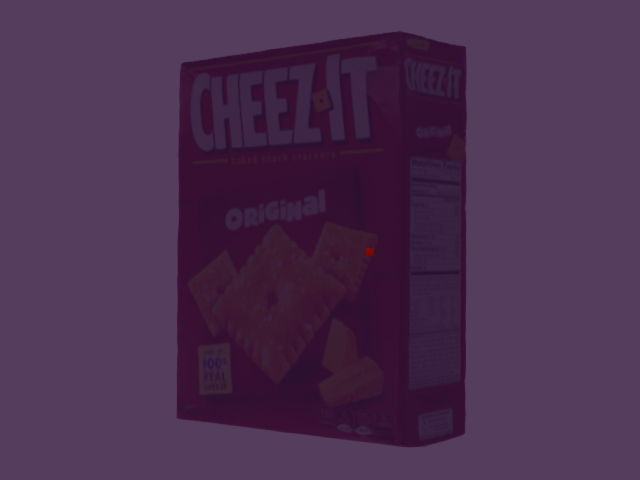

In [15]:
viz_desciptor(1)

# b.clear()
b.show_cloud("2", all_3d_coords.reshape(-1,3), color=b.RED)

torch.Size([1, 1536, 45, 34])


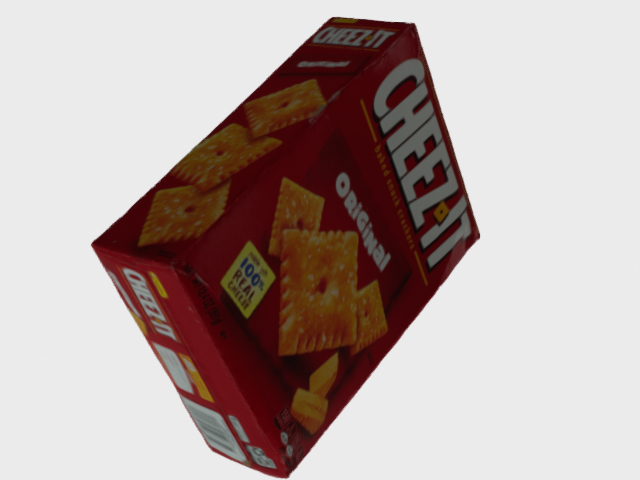

In [26]:
viz.clear()
mesh = o3d.io.read_triangle_model(mesh_filename)
pose = b.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(1),
    b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 0.6, 0.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)), 0.0001, 0.0001)
mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
mesh.meshes[0].mesh.transform(pose)
viz.render.scene.add_model(f"1", mesh)

test_rgbd = viz.capture_image(rgbd.intrinsics, jnp.eye(4))
target_embeddings = get_embeddings(test_rgbd)
b.get_rgb_image(test_rgbd.rgb)

In [27]:
similarity = jnp.einsum("iab, ik->abk", target_embeddings, all_embeddings)
order = jnp.argsort(-similarity.max([0,1]))

0.9240557
272 326


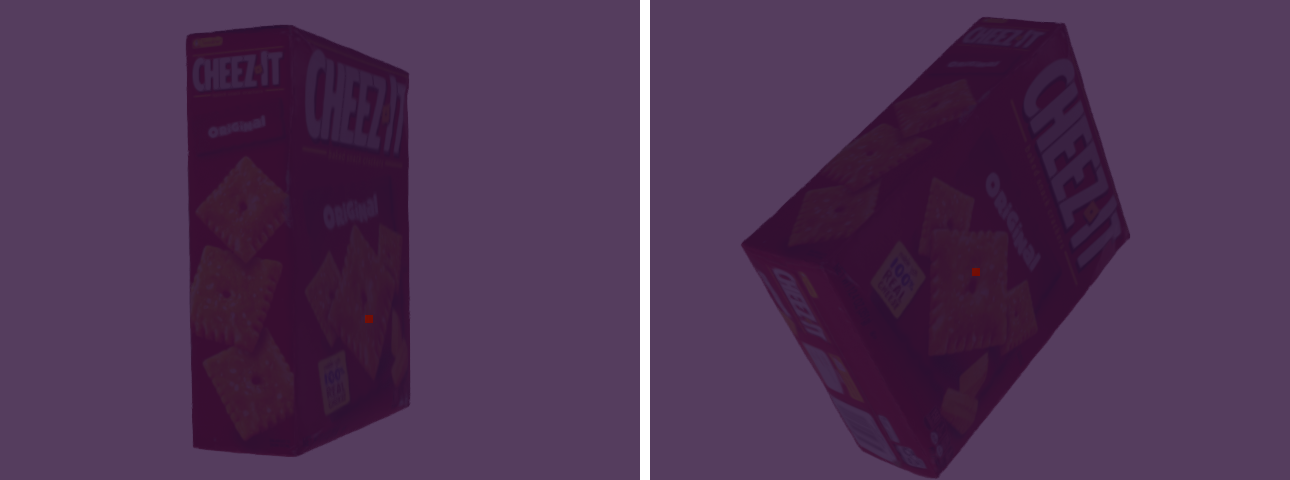

In [37]:
descriptor_idx = order[9]
print(similarity[:,:,descriptor_idx].max())
ii,jj = jnp.unravel_index(similarity[:,:,descriptor_idx].argmax(), similarity[:,:,descriptor_idx].shape)
print(ii,jj)

b.hstack_images([viz_desciptor(descriptor_idx),x_marks_the_spot_overlay_viz(ii,jj, test_rgbd)])

In [ ]:
t1,t2 = 1,2
keys = jax.random.split(key)[1]
ii,jj = coords[t1][:,jax.random.choice(key, coords[t1].shape[1], (50,))]
selected_embedding = embeddings[t1][:,ii,jj]
print(ii,jj)
similarity = jnp.einsum("iab, ik->abk", embeddings[t2], selected_embedding)
similarity_img = b.get_depth_image(similarity, min=-1.0, max=1.0)

iii,jjj = jnp.unravel_index(similarity.argmax(), similarity.shape)

point = jnp.zeros_like(similarity)
point = point.at[ii-4:ii+4,jj-4:jj+4].set(1.0)
point_img =b.get_depth_image(point)


point2 = jnp.zeros_like(similarity)
point2 = point2.at[iii-4:iii+4,jjj-4:jjj+4].set(1.0)
point2_img =b.get_depth_image(point2)

print(similarity.max())

b.hstack_images([b.overlay_image(point_img,b.get_rgb_image(rendered_images[t1].rgb), 0.4),
                 b.overlay_image(point2_img,b.get_rgb_image(rendered_images[t2].rgb), 0.4),
                 b.overlay_image(similarity_img,b.get_rgb_image(rendered_images[t2].rgb)),
                 similarity_img,
                 ])

In [ ]:


mask_ = 1.0 * mask
mask_ = mask_.at[ii-4:ii+4,jj-4:jj+4].set(2.0)
b.get_depth_image(mask_)
selected_embedding = embeddings[:,ii,jj]
similarity1 = jnp.einsum("iab, i->ab", embeddings, selected_embedding)
v1 = b.get_depth_image(similarity1, min=-1.0, max=1.0)
r1 = b.get_rgb_image(rgbd.rgb)

similarity2 = jnp.einsum("iab, i->ab", embeddings2, selected_embedding)
v2 = b.get_depth_image(similarity2, min=-1.0, max=1.0)
r2 = b.get_rgb_image(rgbd2.rgb)
b.hstack_images(
    [r1, b.get_depth_image(mask_), b.overlay_image(r1, b.get_depth_image(mask_)), r2,v2,b.overlay_image(r2,v2, alpha=0.8)]
)

In [40]:
rendered_rgbd.segmentation

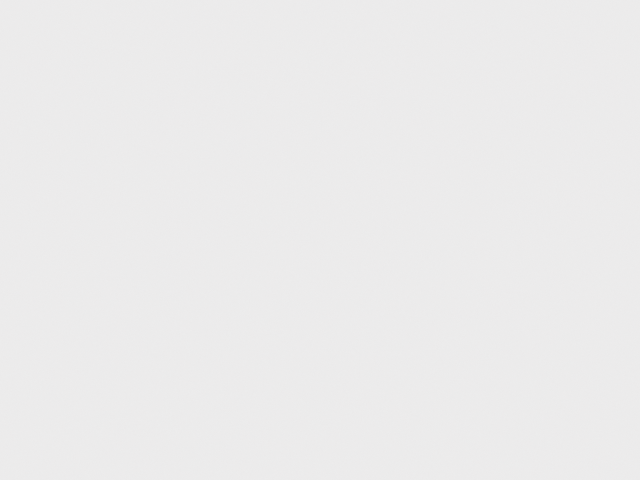

In [7]:
viz.make_mesh_from_file(mesh_paths[2], ), scaling_factor=1.0/1000.0)

TypeError: scale(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cuda.pybind.geometry.Geometry3D, scale: float, center: numpy.ndarray[numpy.float64[3, 1]]) -> open3d.cuda.pybind.geometry.Geometry3D
    2. (self: open3d.cuda.pybind.geometry.Geometry3D, scale: float, center: numpy.ndarray[numpy.float64[3, 1]]) -> open3d.cuda.pybind.geometry.Geometry3D

Invoked with: TriangleMesh with 8300 points and 15728 triangles., 0.001

torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])


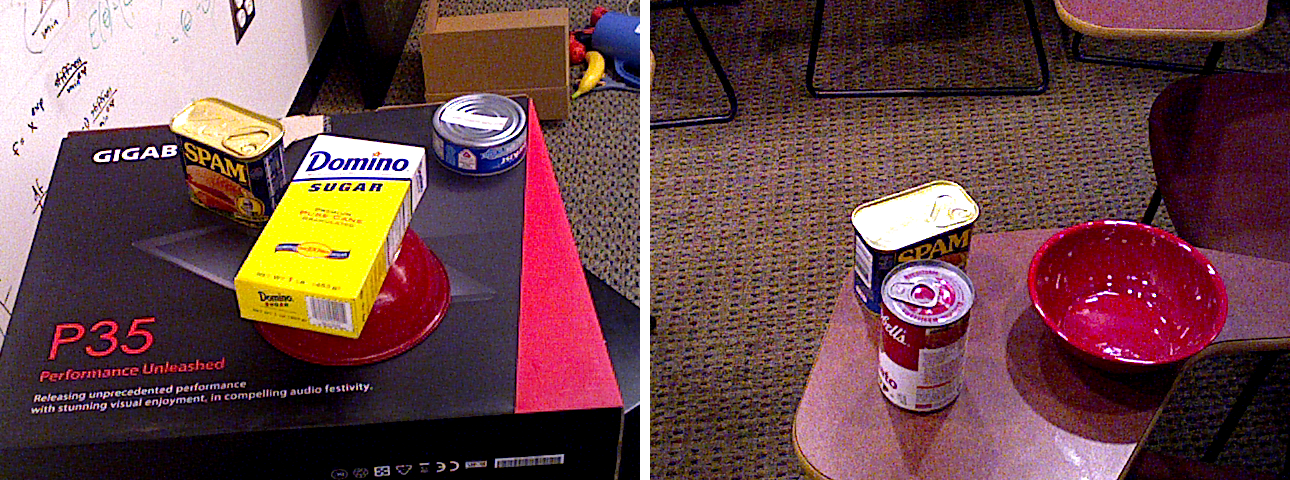

In [4]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.ycb_loader.get_test_img('49', '1', bop_ycb_dir)

embeddings = get_features(rgbd)

rgbd2, gt_ids2, gt_poses2, masks2 = b.ycb_loader.get_test_img('49', '1', bop_ycb_dir)
rgbd2, gt_ids2, gt_poses2, masks2 = b.ycb_loader.get_test_img('53', '1', bop_ycb_dir)
embeddings2 = get_features(rgbd2)

b.hstack_images([
    b.get_rgb_image(rgbd.rgb),
    b.get_rgb_image(rgbd2.rgb),
])

In [5]:
object_index = 2
mask = masks[object_index]
coords = jnp.vstack(jnp.where(mask))
key = jax.random.PRNGKey(10)

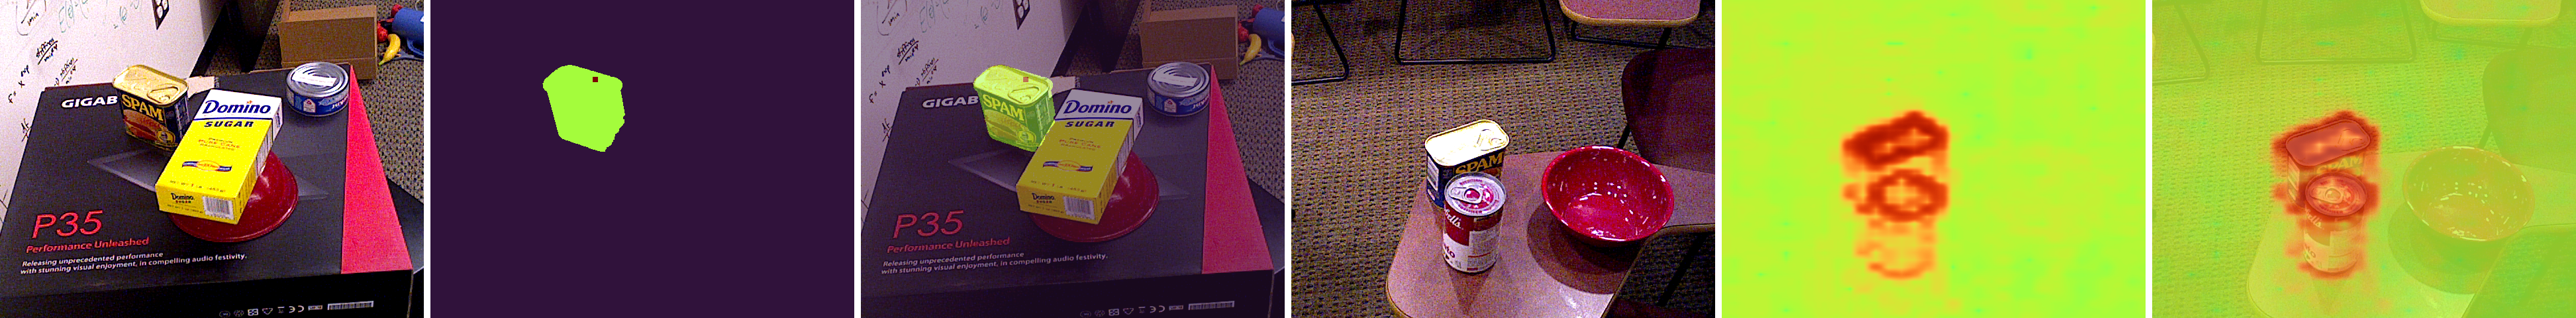

In [7]:
selected_embedding.shape

(1536,)